In [ ]:
# Importing necessary libraries for deep learning, data handling, and visualization
!pip install torch torchvision

In [ ]:
import torch
import pandas as pd
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
RANDOM_SEED = 42 # Setting random seed for reproducibility
BATCH_SIZE = 32
EPOCHS = 1  # Number of epochs set to 1 for quick run, ideally use more (e.g., 10)
LEARNING_RATE = 1e-4
NUM_CLASSES = 10  # Number of classes in MNIST dataset (digits 0-9)
PATCH_SIZE = 4
IMG_SIZE = 28  # Image size in MNIST dataset (28x28 pixels)
IN_CHANNELS = 1  # Number of input channels (1 for grayscale images)
NUM_HEADS = 8
DROPOUT = 0.001
HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION = "gelu"
NUM_ENCODERS = 4  # Number of transformer encoder layers
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS  # Embedding dimension for each patch
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2  # Total number of patches in the image

In [ ]:
# Setting seeds for reproducibility in different libraries
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

In [ ]:
# Setting device to GPU if available, else CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Patch Embedding class to convert image patches into embeddings
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
            ),
            nn.Flatten(2)  # Flattening the output
        )

        self.cls_token = nn.Parameter(torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)

        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = self.position_embeddings + x
        x = self.dropout(x)
        return x

In [ ]:
# Testing the PatchEmbedding class
model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape)  # Printing the shape of the output

torch.Size([512, 50, 16])


In [ ]:
# Vision Transformer (ViT) class definition
class ViT(nn.Module):
    def __init__(self, num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
        super().__init__()
        self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )

    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :])
        return x

In [ ]:
# Testing the ViT class
model = ViT(NUM_PATCHES, IMG_SIZE, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape)  # Printing the shape of the output

torch.Size([512, 10])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
# Define transformations for the training and testing sets
transform = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
# Download and load the MNIST dataset
train_dataset = MNIST(root='.', train=True, download=True, transform=transform)
test_dataset = MNIST(root='.', train=False, download=True, transform=transform)

In [ ]:
# Split the training dataset into training and validation datasets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [ ]:
# Define the data loaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# Print the sizes of the datasets
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 48000
Validation set size: 12000
Test set size: 10000


In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)

In [ ]:
# Training loop
start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):  # Loop over the epochs
    model.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0
    for idx, (img, label) in enumerate(tqdm(train_dataloader, position=0, leave=True)):  # Loop over the training batches
        img, label = img.to(device), label.to(device)

        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)

        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())

        loss = criterion(y_pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx + 1)

    # Validation loop
    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0
    with torch.inference_mode():
        for idx, (img, label) in enumerate(tqdm(val_dataloader, position=0, leave=True)):  # Loop over the validation batches
            img, label = img.to(device), label.to(device)
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)

            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())

            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
    val_loss = val_running_loss / (idx + 1)

    # Printing the training and validation losses and accuracies
    print("-" * 30)
    print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print(f"Train Accuracy EPOCH {epoch+1}: {sum(1 for x, y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
    print(f"Valid Accuracy EPOCH {epoch+1}: {sum(1 for x, y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}")
    print("-" * 30)

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")  # Printing the total training time

100%|██████████| 375/375 [00:02<00:00, 164.71it/s]


------------------------------
Train Loss EPOCH 1: 1.5369
Valid Loss EPOCH 1: 0.8834
Train Accuracy EPOCH 1: 0.4856


100%|██████████| 1/1 [00:42<00:00, 42.99s/it]

Valid Accuracy EPOCH 1: 0.7660
------------------------------
Training Time: 43.00s


In [ ]:
torch.cuda.empty_cache()  # Clearing GPU cache

In [ ]:
# Testing the model and making predictions on test dataset

labels = []
ids = []
imgs = []
model.eval()
with torch.inference_mode():
    test_labels = []
    test_preds = []
    for img, label in tqdm(test_dataloader, position=0, leave=True):
        img, label = img.to(device), label.to(device)
        outputs = model(img)

        predicted_labels = torch.argmax(outputs, dim=1)

        ids.extend(label.tolist())
        imgs.extend(img.detach().cpu())
        labels.extend(predicted_labels.cpu().tolist())

        test_labels.extend(label.cpu().detach())
        test_preds.extend(predicted_labels.cpu().detach())

100%|██████████| 313/313 [00:02<00:00, 146.54it/s]


<Figure size 640x480 with 0 Axes>

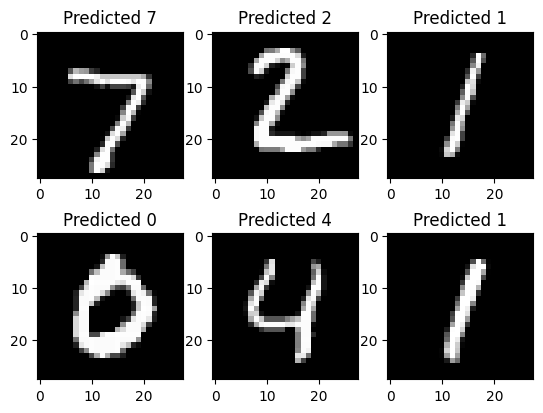

In [ ]:
# Plotting a few test images with predicted labels
plt.figure()
f, axarr = plt.subplots(2, 3)
counter = 0
for i in range(2):
    for j in range(3):
        axarr[i][j].imshow(imgs[counter].squeeze(), cmap="gray")
        axarr[i][j].set_title(f"Predicted {labels[counter]}")
        counter += 1

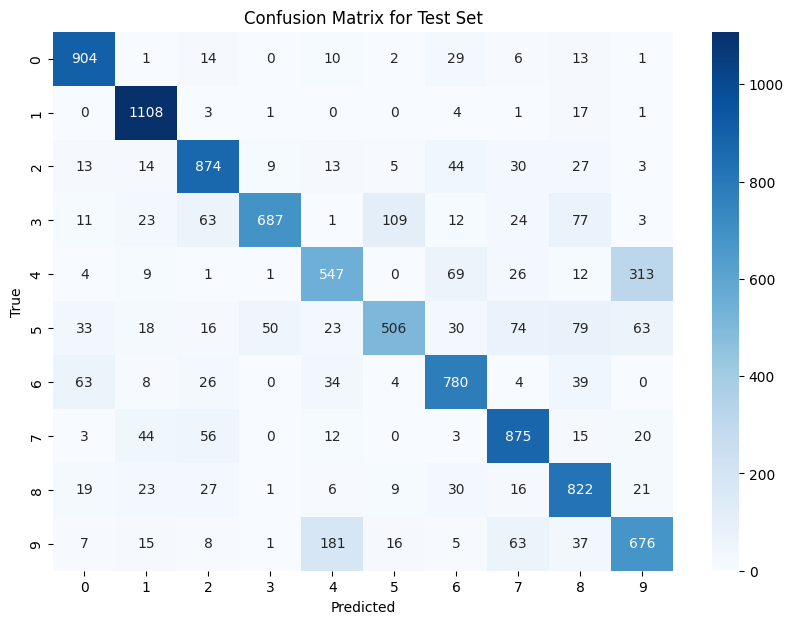

Test Accuracy: 0.7779


In [ ]:
# Calculating the confusion matrix for test set
true_test_labels = [int(label) for label in test_labels]
predicted_test_labels = [int(pred) for pred in test_preds]
cm_test = confusion_matrix(true_test_labels, predicted_test_labels)

# Visualizing the confusion matrix for test set
plt.figure(figsize=(10, 7))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Calculate and print test accuracy
test_accuracy = sum(1 for x, y in zip(predicted_test_labels, true_test_labels) if x == y) / len(true_test_labels)
print(f"Test Accuracy: {test_accuracy:.4f}")